# Machine Learning In Multi-WavelengthGalaxy/Quasars Evolution: Photometric Redshift Estimation

# Walter Silima
The code used for this project was adopted Chaka Mofokeng:
https://github.com/Mofokeng-C/Classification-Photo-z_Regression_Demo 

In [1]:
# Loading necessary modlules

import os 
import os.path as osp
import itertools
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as pl
pl.rcParams['axes.labelsize'] = 16
pl.rcParams['axes.titlesize'] = 16

import pandas as pd
import seaborn as sns
pl.style.use('seaborn')
import timeit

from astropy.stats import bayesian_blocks
from scipy.stats import binned_statistic,norm, bayes_mvs
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import gaussian_kde

from sklearn.linear_model import LinearRegression
from astropy.wcs import WCS # my additional package
from sklearn.tree import DecisionTreeRegressor

from scipy.stats import gaussian_kde

%matplotlib inline

In [2]:
# Defining function

def Preprocessing(filename, task='R', N=1000000):
    '''This function processes the data for a given task and returns the processed data.
    parameters:
    filename - path to the fits file
    task - process to be executed, default is Classification (c,C) another options is Regression (r,R)
    N - number of data point to use for data points
    
    returns:
    Arrays of data split into training and testng data depending on the task at hand.
    '''
    fp = pf.open(filename, memmap=True)
    data = fp[1].data
    fp.close()
    
    #Change the value of n to select only a subset of the data
    data = data[:N] # Only looking for 1000000 points
    
    #df = df.iloc[:n]
    ID = data['objID']
    u = data['dered_u']
    g = data['dered_g']
    r = data['dered_r']
    i = data['dered_i']
    z = data['dered_z']
    w1 = data['w1mpro']
    w2 = data['w2mpro']
    
    # use color as features – color is the difference of 
    # magnitudes between two different filter bands.
    # features: [u-g, g-r, r-i, i-z, z-w1, w1-w2]
    
    
     # feaures
    x = np.vstack([np.array(r), 
                   np.array(u) - np.array(g), 
                   np.array(g) - np.array(r), 
                   np.array(r) - np.array(i), 
                   np.array(i) - np.array(z), 
                   np.array(z) - np.array(w1), 
                   np.array(w1) - np.array(w2)]).T
    
    
    # keep track of all indices
    indices = np.arange(x.shape[0])
    
    # Regression
    if task == 'r' or task == 'R':
        # conditions on magnitude values, #the sources detected and making sure that there is a reasonable measurement.
        cond_u = indices[np.logical_and(u>13.0,u<20.0)]
        cond_g = indices[np.logical_and(g>14.0,g<22.2)]
        cond_r = indices[np.logical_and(r>14.0,r<22.2)]
        cond_i = indices[np.logical_and(i>14.0,i<21.3)]
        cond_z = indices[np.logical_and(z>12.0,z<20.5)]
        
        # index of where all conditions are true
        cond_u_g = cond_u[np.in1d(cond_u,cond_g)]
        cond_u_g_r = cond_u_g[np.in1d(cond_u_g,cond_r)]
        cond_u_g_r_i = cond_u_g_r[np.in1d(cond_u_g_r,cond_i)]
        cond_u_g_r_i_z = cond_u_g_r_i[np.in1d(cond_u_g_r_i, cond_z)]
    
        # get values that satisfy the conditions
        class_0 = np.array([data['specclass'][i] for i in cond_u_g_r_i_z])
        class_1 = np.array([data['specsubclass'][i] for i in cond_u_g_r_i_z])
        redshift = np.array([data['zspec'][i] for i in cond_u_g_r_i_z])
        #warning = np.array([data['zspecwarning'][i] for i in cond_ug_r_i_z]) because all the values are equal to zeros, 
        # we do not need this value.
        
        # gather all rows
        x_data = np.zeros((len(cond_u_g_r_i_z),x.shape[1]))
        for i in range(len(cond_u_g_r_i_z)):
            x_data[i] = x[cond_u_g_r_i_z[i]]
        
        # keep track of all indices
        indices = np.arange(x_data.shape[0])
        
        # for regression we only use GALAXY and QSO data
        ix = np.where(class_0 != 'STAR')[0]
        i_gal = indices[class_0 == 'GALAXY'] # index of GALAXY class
        print('Number of galaxies: {}'.format(len(i_gal)))
        
        i_qso = indices[class_0 == 'QSO'] # index of QSO class
        print('\n\nNumber of quasars: {}'.format(len(i_qso)))
        
        y_z = redshift
        #x_train, x_test, y_ztrain, y_ztest, i_train, i_test = train_test_split(x_data[ix], y_z[ix], ix, test_size=0.25) #splitting data into 75% and 25% train and test datasets, respectively
        
        return x_data, y_z, i_gal, i_qso

In [72]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pl.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    pl.imshow(cm, interpolation='nearest', cmap=cmap)
    pl.title(title)
    pl.colorbar()
    tick_marks = np.arange(len(classes))
    pl.xticks(tick_marks, classes, rotation=45)
    pl.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pl.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    pl.tight_layout()
    pl.ylabel('True label')
    pl.xlabel('Predicted label')

In [73]:
def photo_z_stats(zpredicted,ztrue):
    '''This function takes the arrays of the predicted and true redshift values
    and returns values used for evaluation of the photo-z regression process
            
    parameters:
    zpredicted - predicted redshift values from the algorithm
    ztrue - ground truth redshift values 
            
    returns:
    del_z_norm - normalized redshift estimation error
    del_z_mean - mean value of the normalized redshift estimation error (a.k.a bias)
    del_z_median - median value of the normalized redshift estimation error
    del_z_RMS - root-mean-square value of the normalized redshift estimation error (a.k.a precision)
    del_z_MAD - median-absolute-deviation value of the normalized redshift estimation error
    del_z_NMAD - normalized-median-absolute-deviation (PS: less sensitive to outliers than the RMS, thus mostly preferred value of precision )
    '''
    # evaluation measures used for photo-z regression
    del_z_norm = (zpredicted-ztrue)/(1+ztrue) # normalized redshift estimation error

    del_z_mean = np.mean(del_z_norm)

    del_z_median = np.median(del_z_norm)

    del_z_RMS = np.std(del_z_norm)

    del_z_MAD = np.median(abs(del_z_norm - np.median(del_z_median)))

    del_z_NMAD = 1.4826*del_z_MAD 

    print('delta(z)_mean = {}; delta(z)_median = {}; sigma(delta(z)) = {}; nmad(delta(z)) = {}'.format(del_z_mean,del_z_median,del_z_RMS,del_z_NMAD))
            
    return del_z_norm, del_z_mean, del_z_median, del_z_RMS, del_z_MAD, del_z_NMAD

In [74]:
def outliers_fractions(delta_z_norm,delta_z_rms):
    '''This function calculation a fraction of sources with large error for a given N.
    formula given as: normalized redshift estimation errors with values greater than 
    N times the standard deviation of the normalized redshift estimation errors.
    
    parameters:
    del_z_norm - normalized redshift estimation error
    del_z_RMS - root-mean-square value of the normalized redshift estimation error (a.k.a precision)

    returns:
    N sigma values
    '''
    sig_1 = abs(delta_z_norm) > (1.*delta_z_rms)
    sigma_1 = (float(len(delta_z_norm[sig_1]))/len(delta_z_norm))*100.

    sig_2 = abs(delta_z_norm) > (2.*delta_z_rms)
    sigma_2 = (float(len(delta_z_norm[sig_2]))/len(delta_z_norm))*100.

    sig_3 = abs(delta_z_norm) > (3.*delta_z_rms)
    sigma_3 = (float(len(delta_z_norm[sig_3]))/len(delta_z_norm))*100.

    sig_4 = abs(delta_z_norm) > 0.15
    sigma_4 = (float(len(delta_z_norm[sig_4]))/len(delta_z_norm))*100.

    print('sigma1 = {}; sigma2 = {}; sigma3 = {}; sigma0.15 = {}'.format(sigma_1,sigma_2,sigma_3,sigma_4))
    
    return sigma_1,sigma_2,sigma_3,sigma_4

In [75]:
def regressor(rg,data,labels, i_gal, i_qso, name='', cl='', lim=[]):
    '''This function gives the plot of photo-z estimates of the given regressor
    parameters:
    rg - the algorithm to perform regression
    x_tr - training dataset
    x_t - test dataset
    y_ztr - photo-z training data
    y_zt - photo-z test data
    i_train - indices of training data 
    i_test - indices of test data
    i_gal - index of GALAXY specclass
    i_qso - index of QSO specclass
    name - name of the regressor
    cl - sources class ('GALAXY','QSO')
    lim - axis limits, default [0.0,0.5] ('GALAXY') ; [0.0,3.5] (QSO)
    
    returns:
    mean of the separation of the predicted and the true redshift.
    median of the separation of the predicted and the true redshift.
    rms of the separation of the predicted and the true redshift.
    nmad of the separation of the predicted and the true redshift.
    
    sigma (1*sigma, 2*sigma, 3*sigma and 4*sigma) of the separation of the predicted and the true redshift.
    plot of predicted and true redshift.
    '''
    
    
    if cl !='' and cl=='GALAXY':
       
        data = data[i_gal]
        labels = labels[i_gal]
        
        x_train, x_test, y_ztrain, y_ztest, i_train, i_test = train_test_split(data, labels, i_gal, test_size=0.20)


        
        rg.fit(x_train,y_ztrain)
        
        y_pred = rg.predict(x_test)
    
        ztest=y_ztest
        zpred=y_pred
        
        del_z_norm, del_z_mean, del_z_median, del_z_RMS, del_z_MAD, del_z_NMAD = photo_z_stats(zpred,ztest)
        
        axis_lim = np.array(lim)
        if axis_lim.size == 0 and axis_lim[1].size == 0:
            print('Invalid axis limits, using defaualt values')
            axis_lim = np.array([[-0.0,0.5],[0.0,0.5]])
        else:
            axis_lim = np.array(lim)
            
        s1, s2, s3, s4 = outliers_fractions(del_z_norm,del_z_RMS)

        str_nmad = r"$\mathbf{NMAD = %.4f}$"%del_z_NMAD
        str_del = r"$\mathbf{RMS = %.4f}$"%del_z_RMS
        
        pl.figure(figsize=(11,11))
        pl.hlines(0.0,axis_lim[0][0],axis_lim[0][1],colors='k',linestyle='solid', label = 'Zspec')
        pl.scatter(ztest, -del_z_norm, c='b', lw=0, s=4)
        
        pl.hlines(del_z_NMAD,axis_lim[0][0],axis_lim[0][1],colors='r',linestyle='dashed')
        pl.hlines(-del_z_NMAD,axis_lim[0][0],axis_lim[0][1],colors='r',linestyle='dashed', label = 'NMAD')

        pl.xlim(axis_lim[0])
        pl.ylim(axis_lim[1])
        pl.title('Photo-z: ' + name + '- GALAXY')
        pl.xlabel(r'$\mathbf{z_{spec}}$', fontsize=14)
        #pl.ylabel(r'$\mathrm{z_{phot} - }$', fontsize=14)
        pl.ylabel(r'$\mathbf{({z_{spec} - z_{phot})/(1+z_{spec}})}$', fontsize=14)
        pl.text(axis_lim[0][1]-(axis_lim[0][1]/4), axis_lim[1][0]-(axis_lim[1][0]/4), str_nmad,fontsize=14)
        pl.text(axis_lim[0][1]-(axis_lim[0][1]/4), axis_lim[1][0]-(axis_lim[1][0]/4)-0.06, str_del,fontsize=14)
        pl.legend(loc = 'upper left')
        pl.savefig(name+cl+'_regression.png')
        return ztest, zpred
    
    else:
        
        data = data[i_qso]
        labels = labels[i_qso]
        x_train, x_test, y_ztrain, y_ztest, i_train, i_test = train_test_split(data, labels, i_qso, test_size=0.20)
        
        # fit training data
        rg.fit(x_train,y_ztrain)
        
        # predict labels of the test data
        y_pred = rg.predict(x_test)
    
        ztest=y_ztest
        zpred=y_pred
        
        del_z_norm, del_z_mean, del_z_median, del_z_RMS, del_z_MAD, del_z_NMAD = photo_z_stats(zpred,ztest)

        axis_lim = np.array(lim)
        if axis_lim.size == 0:
            print('Invalid axis limits, using defaualt values')
            axis_lim = np.array([[-0.5,0.5],[0.0,3.5]])
        else:
            axis_lim = np.array(lim)
            
        
        s1, s2, s3, s4 = outliers_fractions(del_z_norm,del_z_RMS)

        str_nmad = r"$\mathbf{NMAD = %.4f}$"%del_z_NMAD
        str_del = r"$\mathbf{RMS = %.4f}$"%del_z_RMS
        
        pl.figure(figsize=(11,11))
        pl.hlines(0.0,axis_lim[0][0],axis_lim[0][1],colors='k',linestyle='solid', label = 'Zspec')
        pl.scatter(ztest, -del_z_norm, c='b', lw=0, s=4)
        
        pl.hlines(del_z_NMAD,axis_lim[0][0],axis_lim[0][1],colors='r',linestyle='dashed')
        pl.hlines(-del_z_NMAD,axis_lim[0][0],axis_lim[0][1],colors='r',linestyle='dashed', label = 'NMAD')

        pl.xlim(axis_lim[0])
        pl.ylim(axis_lim[1])
        pl.title('Photo-z: ' + name + '- Quasars')
        pl.xlabel(r'$\mathbf{z_{spec}}$', fontsize=14)
        #pl.ylabel(r'$\mathrm{z_{phot} - }$', fontsize=14)
        pl.ylabel(r'$\mathbf{({z_{spec} - z_{phot})/(1+z_{spec}})}$', fontsize=14)
        pl.text(axis_lim[0][1]-(axis_lim[0][1]/4), axis_lim[1][0]-(axis_lim[1][0]/4), str_nmad,fontsize=14)
        pl.text(axis_lim[0][1]-(axis_lim[0][1]/4), axis_lim[1][0]-(axis_lim[1][0]/4)-0.1, str_del,fontsize=14)
        pl.legend(loc = 'upper left')
        pl.savefig(name+cl+'_regression.png')
        return ztest, zpred

In [76]:
def roc_curve(y_t, proba, name=''):
    '''This function returns the roc curve plot 
    paramters:
    y_t - test dataset labels
    proba - proabaility of the predicted label by the classifier
    name - name of the classifyer
    
    returns a plot of the roc curve of the data'''
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(proba[0])):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test, proba[:,i], pos_label=i)
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    #Plot the roc_curve
    pl.figure(figsize=(11,11))
    
    pl.title(name)
    pl.xlabel('false positive rate')
    pl.ylabel('true positive rate')
    
    pl.plot(fpr[0],tpr[0], label='ROC curve for GALAXIES (area = %0.2f)' %roc_auc[0])
    pl.plot(fpr[1],tpr[1], label='ROC curve for STARS (area = %0.2f)' %roc_auc[1])
    pl.plot(fpr[2],tpr[2], label='ROC curve for QSOs (area = %0.2f)' %roc_auc[2])
    pl.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    pl.grid(True)
    pl.legend(loc=4)


In [77]:
def feature_importance(cl,importance,x_tr, x_t, y_tr, y_t,thresh=0.15):
    '''This function Create a selector object that will use 
    the random forest classifier to identify 
    features that have an importance of more than the given
    threshold.
    parameters:
    cl - the algorithm to perform classification
    importance - ranking of the important features of the dataset
    thresh - feature importance threshold, default thresh=0.15
    x_tr - training dataset
    x_t - test dataset
    y_tr - training dataset labels
    y_t - test dataset labels
    
    returns:
    plot of feature importance.
    '''
    
    sfm = SelectFromModel(cl, threshold=thresh)
    
    # Train the selector
    sfm.fit(x_tr, y_tr)

    # Transform the data to create a new dataset containing only the most important features
    # Note: We have to apply the transform to both the training X and test X data.
    x_important_train = sfm.transform(x_tr)
    x_important_test = sfm.transform(x_t)

    # Create a new random forest classifier for the most important features
    rs_important = RandomForestClassifier(30)

    # Train the new classifier on the new dataset containing the most important features
    rs_important.fit(x_important_train, y_tr)
    y_rs_important = rs_important.predict(x_important_test)
    proba_ = rs_important.predict_proba(x_important_test)
    acu_important=acc(y_t, y_rs_important)
    
    print ('\n\nAccuracy for RF (feature selection): ' + repr(acu_important))# printing out your results
    print (metrics.classification_report(y_t, y_rs_important,target_names=['SFGs', 'STARS', 'QSOs'], digits=4))



    std = np.std([cl.feature_importances_ for tree in cl.estimators_],axis=0)
    
    t_label = ['r','u-g' , 'g-r', 'r-i', 'i-z', 'z-w1', 'w1-w2']
    labels = []
    
    indices = np.argsort(importance)[::-1]
    for f in range(len(t_label)):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importance[indices[f]]))
        labels.append(t_label[indices[f]])
    
    # Plot the feature importances of the forest
    
    #i = np.arange(x.shape[1])
    #labels = t_label[indices[i]]
    
    pl.figure(figsize=(11,11))
    pl.title("Feature importances")
    pl.bar(range(len(labels)), importance[indices],
           color="r", yerr=std[indices], align="center")
    pl.xticks(range(len(labels)),labels, rotation = 45 )
    pl.xlim([-1, len(labels)])
    #pl.savefig('rf_feature_importance.png')

In [78]:
# making the zspec vs photo-z
def zplot(zpred, ztest, name):
    del_z_norm, del_z_mean, del_z_median, del_z_RMS, del_z_MAD, del_z_NMAD = photo_z_stats(zpred,ztest)
    
    s1, s2, s3, s4 = outliers_fractions(del_z_norm,del_z_RMS)

    str_nmad = r"$\mathbf{\sigma_{NMAD} = %.4f}$"%del_z_NMAD
    str_del = r"$\mathbf{\delta = %.4f}$"%del_z_RMS
    
    pl.figure(figsize=(9,9))
    pl.hist2d(zpred, ztest, bins=(50, 50), cmap=pl.cm.Reds)

    pl.scatter(zpred, ztest, c='b', lw=0, s=3.5)
    pl.plot([0, 0.4-del_z_NMAD], [del_z_NMAD, 0.4], ls="--", c="k", label = 'NMAD')
    pl.plot([0, 0.4], [0, 0.4], ls="--", c="r", label = 'Zspec')
    pl.plot([del_z_NMAD,0.4], [0,0.4 - del_z_NMAD], ls="--", c="k")
    pl.xlim([0.0,0.4])
    pl.ylim([0.0,0.4])
    # pl.ylim(axis_lim)
    pl.title(name)
    pl.xlabel(r'$\mathbf{z_{spec}}$', fontsize=14)
    pl.ylabel(r'$\mathbf{z_{photo}}$', fontsize=14)
    pl.colorbar()
    pl.show()
    return p1

In [79]:
# making a density plot
# reference
# https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib
def denplot(zpred, ztest, name, typ = ''):
    
    if typ == 'GALAXY':
        del_z_norm, del_z_mean, del_z_median, del_z_RMS, del_z_MAD, del_z_NMAD = photo_z_stats(zpred,ztest)   
    
        s1, s2, s3, s4 = outliers_fractions(del_z_norm,del_z_RMS)

        str_nmad = r"$\mathbf{NMAD = %.4f}$"%del_z_NMAD
        str_del = r"$\mathbf{RMS = %.4f}$"%del_z_RMS
        
        # Calculate the point density
        xy = np.vstack([zpred,ztest])
        z = gaussian_kde(xy)(xy)
    
        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        zpred, ztest, z = zpred[idx], ztest[idx], z[idx]
        
        pl.figure(figsize=(11,11))
        pl.plot([0, 0.4-del_z_NMAD], [del_z_NMAD, 0.4], ls="--", c="k", label = 'NMAD')
        pl.plot([0, 0.4], [0, 0.4], ls="--", c="r", label = 'Zspec')
        pl.plot([del_z_NMAD,0.4], [0,0.4 - del_z_NMAD], ls="--", c="k")
#         pl.scatter(ztest, zpred, c='k', lw=0, s=4)
        pl.scatter(zpred, ztest, c=z, s=3.5, cmap='jet', lw=0)
    
        pl.xlim(0, 0.4)
        pl.ylim(0, 0.4)
        pl.title(name)
        pl.xlabel(r'$\mathbf{z_{spec}}$', fontsize=14)
        pl.ylabel(r'$\mathbf{ z_{phot}}$', fontsize=14)
        pl.text(0.3, 0.01, str_nmad,fontsize=14)
#         pl.text(0.3, 0.02, str_del,fontsize=14)
        pl.legend(loc = 'upper left')
        pl.colorbar()
        pl.savefig(name+typ+'zspec.png')
        pl.show()
    
    else:
        del_z_norm, del_z_mean, del_z_median, del_z_RMS, del_z_MAD, del_z_NMAD = photo_z_stats(zpred,ztest)   
    
        s1, s2, s3, s4 = outliers_fractions(del_z_norm,del_z_RMS)

        str_nmad = r"$\mathbf{NMAD = %.4f}$"%del_z_NMAD
        str_del = r"$\mathbf{RMS = %.4f}$"%del_z_RMS
        
        # Calculate the point density
        xy = np.vstack([zpred,ztest])
        z = gaussian_kde(xy)(xy)
    
        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        zpred, ztest, z = zpred[idx], ztest[idx], z[idx]
        
        pl.figure(figsize=(11,11))
        pl.plot([0, 3.5-del_z_NMAD], [del_z_NMAD, 3.5], ls="--", c="k", label = 'NMAD')
        pl.plot([0, 3.5], [0, 3.5], ls="--", c="r", label = 'Zspec')
        pl.plot([del_z_NMAD,3.5], [0,3.5 - del_z_NMAD], ls="--", c="k")
#         pl.scatter(ztest, zpred, c='k', lw=0, s=4)
        pl.scatter(zpred, ztest, c=z, s=3.5, cmap='jet', lw=0)
    
        pl.xlim(0, 3.5)
        pl.ylim(0, 3.5)
        pl.title(name)
        pl.xlabel(r'$\mathbf{z_{spec}}$', fontsize=14)
        pl.ylabel(r'$\mathbf{ z_{phot}}$', fontsize=14)
        pl.text(2.5, 0.5, str_nmad,fontsize=14)
#         pl.text(2.5, 0.6, str_del,fontsize=14)
        pl.legend( loc = 'upper left')
        pl.colorbar()
        pl.savefig(name+typ+'zspec.png')
        pl.show()
    
    

# Load data from the catalogue

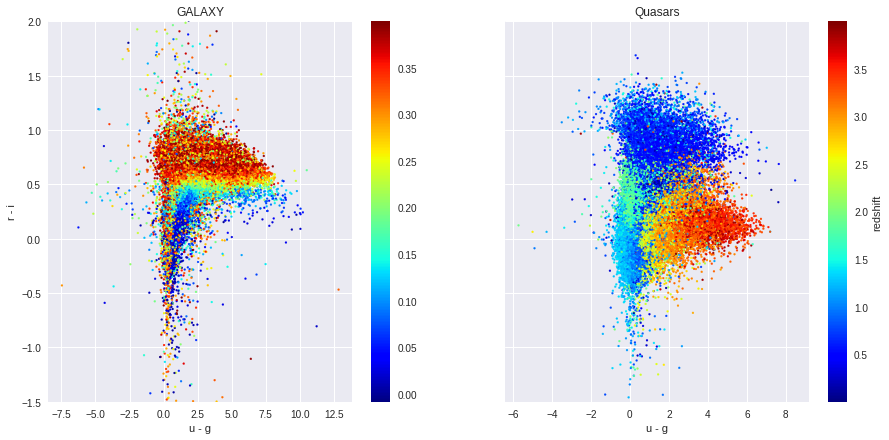

In [59]:
# loading the data from the machine
file = osp.join("sdss_all_small_dr16_allwise_red.fits")
fp = pf.open(file, memmap=True)
data = fp[1].data
fp.close

# number of elements in the data
N_all = len(data)


#Change the value of n to select only a subset of the data
N = len(data)
data = data[:N]


ID = data['objID']
u = data['dered_u']
g = data['dered_g']
r = data['dered_r']
i = data['dered_i']
z = data['dered_z']
w1 = data['w1mpro']
w2 = data['w2mpro']
   
    
#Splitting photometric data into test and train data
x = np.vstack([np.array(r), 
               np.array(u) - np.array(g), 
               np.array(g) - np.array(r), 
               np.array(r) - np.array(i), 
               np.array(i) - np.array(z), 
               np.array(z) - np.array(w1), 
               np.array(w1) - np.array(w2)]).T


# create a figure and axis
labels = ["r","u - g","g - r","r - i","i - z","z - w1","w1 - w2"]
nlabels = len(labels)

# select two random features
ilabels = np.random.choice(nlabels,2)

# select GALAXY and QSO datasets only
i_gal = np.where(data['specclass']=='GALAXY')[0] 
gal = x[i_gal] # GALAXY features
z_gal = data['zspec'][i_gal] # GALAXY spectroscopic redshifts

i_qso = np.where(data['specclass']=='QSO')[0]
qso = x[i_qso] # QSO features
z_qso = data['zspec'][i_qso] # QSO spectroscopic redshifts

# plot data points
fig, ax = pl.subplots(1,2,sharey=True,figsize=(15,7))

z_gal_new = []
gal_new = []
for i in range( len(z_gal)):
    if z_gal[i] < 0.4:
        z_gal_new.append(z_gal[i])
        gal_new.append(gal[i])
z_qso_new = []
qso_new = []
for i in range(len(z_qso)):
    if z_qso[i] < 4:
        z_qso_new.append(z_qso[i])
        qso_new.append(qso[i])

gal_new = np.array(gal_new)
qso_new = np.array(qso_new)
ax[0].set_title('GALAXY')
p = ax[0].scatter(gal_new[:,1], gal_new[:,3], c=z_gal_new, lw=0.2,s=4, cmap='jet') 

ax[0].set_xlabel(labels[1])
ax[0].set_ylabel(labels[3])
ax[0].set_ylim(-1.5, 2)
pl.colorbar(p,ax=ax[0])

ax[1].set_title('Quasars')

p1 = ax[1].scatter(qso_new[:,1], qso_new[:,3], c=z_qso_new,lw=0.2, s=4, cmap='jet')
ax[1].set_xlabel(labels[1])
ax[0].set_ylim(-1.5, 2)
pl.colorbar(p1,ax=ax[1], label='redshift')
pl.savefig('sample_data')
pl.show()


In [60]:
print(len(data))
print(len(i_gal))
print(len(i_qso))
print(len(data) - (len(i_gal) + len(i_qso)))

2418325
1683116
412051
323158


In [61]:
print(np.mean(z_gal))

0.39680508


In [62]:
# import seaborn as sns
# sns.set(font_scale=2)
# sns.pairplot(df, hue="specclass",)

# REGRESSION

In [63]:
x_data, y_data,i_gal, i_qso = Preprocessing(file, task = 'R', N=N_all)

Number of galaxies: 285685


Number of quasars: 124688


# Random Forest Regression

In [64]:
# creating a grid for n_estimators
random_forest = RandomForestRegressor(random_state = 42)

# we need to look at the parameters
from pprint import pprint

print('Parameters currently in use: \n')
pprint(random_forest.get_params())

Parameters currently in use: 

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


# Random Hyperparameters Grid

In [65]:
# from sklearn.model_selection import RandomizedSearchCV

# # the number of trees in the forest 
# n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num =10)]

# # The number of features to consider in the forest 
# M=max_features = ['auto', 'sqrt']

# # the maximum number of levels in the forest
# max_depth = [int(x) for x in np.linspace(10, 200, 10)]
# max_depth.append(None)

# # the minimum number of samples required to split at a node
# min_samples_split = [2, 5, 10]

# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]

# # Method of selecting samples for training each tree
# bootstrap = [True, False]

# # creating a random grid

# random_grid = {'n_estimators': n_estimators,
#               'max_features': max_features, 
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}

# pprint(random_grid)

# # Reference
# # https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Random search Training

In [66]:

# # making use of the random grid to search for the best hyperparameters
# # create a model to tune
# rand_forest = RandomForestRegressor()

# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores

# rand_forest_random = RandomizedSearchCV(estimator = rand_forest, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# # Fit the random search model
# rand_forest_random.fit(xg_train, yg_ztrain)



THE BEST PARAMETERS FOR THE RANDOM FOREST

In [67]:
# rand_forest_random.best_params_

In [68]:
# best_random = rand_forest_random.best_estimator_

# GALAXIES

delta(z)_mean = 0.00048781969449856197; delta(z)_median = 0.0004286060399811165; sigma(delta(z)) = 0.018738132543349256; nmad(delta(z)) = 0.01358401006101437
sigma1 = 21.492202950802458; sigma2 = 3.545863451003728; sigma3 = 0.7630782155170904; sigma0.15 = 0.08750896966939112


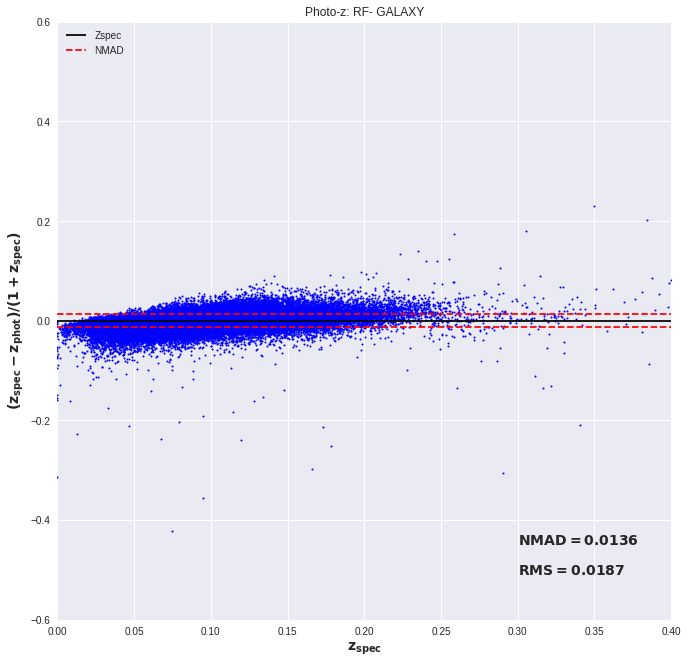

In [70]:
# RandomForestRegressor
# ztest_rfg, zpred_rfg = regressor(RandomForestRegressor(n_estimators = 300,min_samples_split = 5, min_samples_leaf = 2, max_features = 'sqrt', max_depth = 94, bootstrap = False),x_data,y_data, i_gal, i_qso, 'RF', 'GALAXY', [[0.0,2.0],[-0.6,0.6]])

best_random = RandomForestRegressor(n_estimators = 300,min_samples_split = 5, min_samples_leaf = 2, max_features = 'sqrt', max_depth = 94, bootstrap = False)
# RandomForestRegressor
ztest_rfg, zpred_rfg = regressor(best_random,x_data,y_data, i_gal, i_qso, 'RF', 'GALAXY', [[0.0,0.4],[-0.6,0.6]])

delta(z)_mean = -0.00011173120506567064; delta(z)_median = -0.00042842241554615014; sigma(delta(z)) = 0.020551436292759063; nmad(delta(z)) = 0.013591432459351816
sigma1 = 18.177363179725923; sigma2 = 2.450251150742951; sigma3 = 0.511052382869244; sigma0.15 = 0.08575879027600329


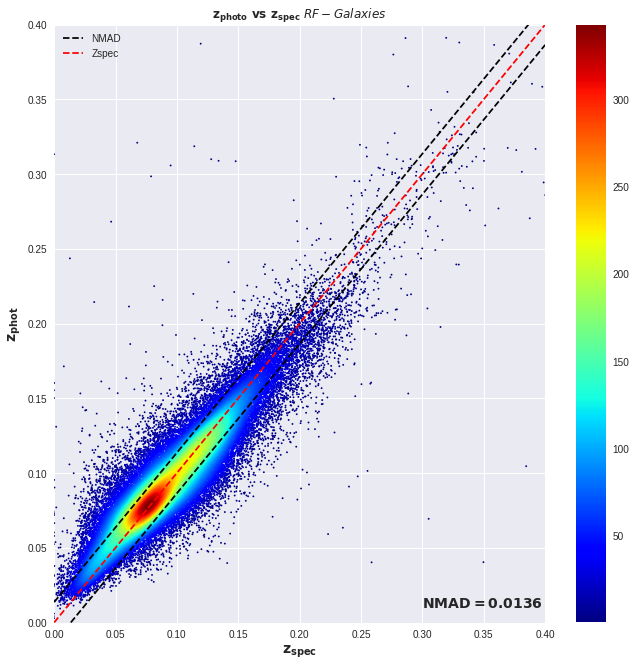

In [80]:
# making a density plot of photo-z versus spec-xz
denplot(ztest_rfg, zpred_rfg, r'$\mathbf{z_{photo}\ vs\ z_{spec}}\ RF-Galaxies$', typ = 'GALAXY')

# For QSO

delta(z)_mean = 0.009731835805179343; delta(z)_median = 0.0036131092573756214; sigma(delta(z)) = 0.09312749257240584; nmad(delta(z)) = 0.03682731476127038
sigma1 = 9.250942336995749; sigma2 = 3.79741759563718; sigma3 = 2.0250220546956452; sigma0.15 = 5.012430828454567


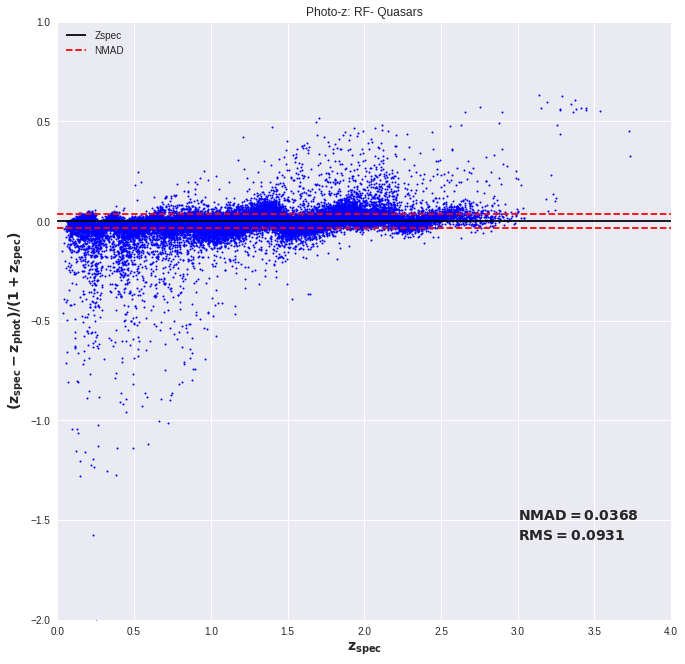

In [81]:
# Random Forest Regressor for quassars
# ztest_rfq, zpred_rfq = regressor(RandomForestRegressor(n_estimators = 200,min_samples_split = 5, min_samples_leaf = 2, max_features = 'sqrt', max_depth = 73, bootstrap = False) ,x_data,y_data, i_gal, i_qso, 'RF', '', [[0.0,4.0],[-2.0,1.0]])

# Random Forest Regressor for quassars
ztest_rfq, zpred_rfq = regressor(best_random,x_data,y_data, i_gal, i_qso, 'RF', '', [[0.0,4.0],[-2.0,1.0]])

delta(z)_mean = -0.0015430994479318733; delta(z)_median = -0.0036001017494198565; sigma(delta(z)) = 0.10586925325563748; nmad(delta(z)) = 0.03657499339470353
sigma1 = 7.57077552329778; sigma2 = 2.9392894378057584; sigma3 = 1.4435800785949153; sigma0.15 = 4.747774480712167


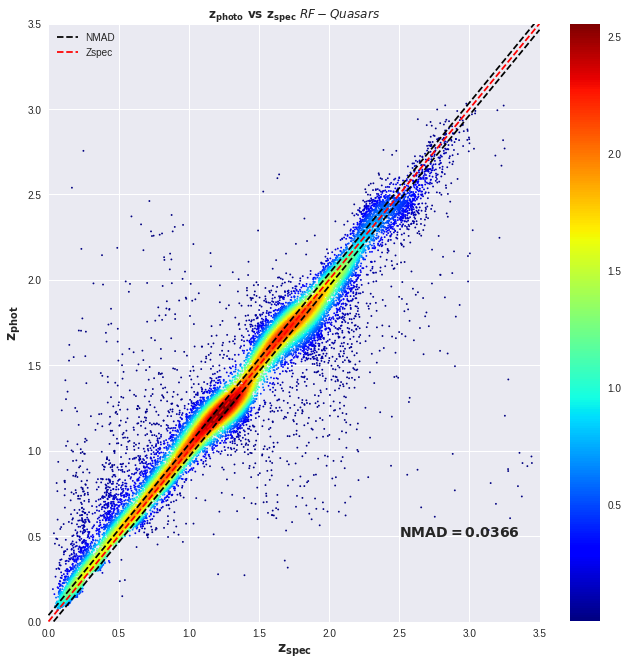

In [82]:
denplot(ztest_rfq, zpred_rfq, r'$\mathbf{z_{photo}\ vs\ z_{spec}}\ RF-Quasars$', "QSO")

# KNN REGRESSOR

# Hyperparameters Grid

In [84]:
# reference
# https://medium.com/datadriveninvestor/k-nearest-neighbors-in-python-hyperparameters-tuning-716734bc557f

# creating a grid for n_estimators
Knnr = KNeighborsRegressor(weights = 'uniform')

# we need to look at the parameters
from pprint import pprint


print('Parameters currently in use: \n')
pprint(Knnr.get_params())

Parameters currently in use: 

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}


# Grid Hyperparameters 

In [85]:
# #List Hyperparameters that we want to tune.
# leaf_size = list(range(1,15))
# n_neighbors = list(range(1,20))
# p=[1,2]
# weights = ['distance', 'uniform']
# algorithm = ['ball_tree', 'kd_tree', 'brute']

# # create a model to tune
# KNNR = KNeighborsRegressor()

# #Convert to dictionary
# hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p, weights = weights, algorithm= algorithm )#Create new KNN object


# regres = GridSearchCV(KNNR, hyperparameters, cv=5)#Fit the model

# best_model = regres.fit(x_train,y_ztrain)#Print The value of best Hyperparameters
# print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
# print('Best p:', best_model.best_estimator_.get_params()['p'])
# print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
# print('Best n_neighbors:', best_model.best_estimator_.get_params()['algorithm'])
# print('Best n_neighbors:', best_model.best_estimator_.get_params()['weights'])

# GALLAXIES

delta(z)_mean = 0.00021701594232581556; delta(z)_median = 3.830246350844391e-05; sigma(delta(z)) = 0.020416775718331337; nmad(delta(z)) = 0.015193941331654786
sigma1 = 21.399443442952904; sigma2 = 3.435602149220295; sigma3 = 0.738575704009661; sigma0.15 = 0.11026130178343281


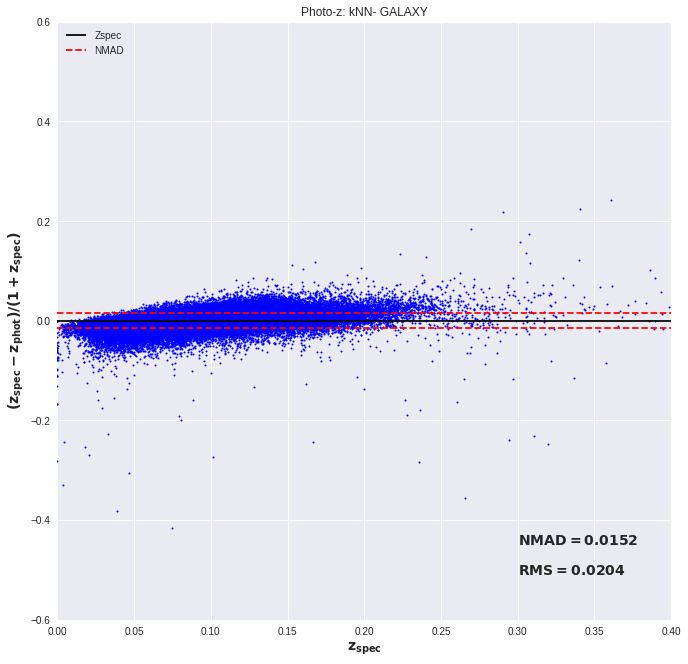

In [86]:
# kNearestRegressor Galaxies
# using 10 nearest neighbors 
kg = KNeighborsRegressor(n_neighbors=10, leaf_size = 30, p = 1, weights='uniform')
ztest_knng , zpred_knng = regressor(kg,x_data,y_data, i_gal, i_qso, 'kNN', 'GALAXY', [[0.0,0.4],[-0.6,0.6]])

delta(z)_mean = 0.00023014016915112734; delta(z)_median = -3.8301001040963456e-05; sigma(delta(z)) = 0.022521641105413437; nmad(delta(z)) = 0.015188135156594215
sigma1 = 17.837828377408684; sigma2 = 2.381994154400826; sigma3 = 0.4900502301485902; sigma0.15 = 0.10326058420988152


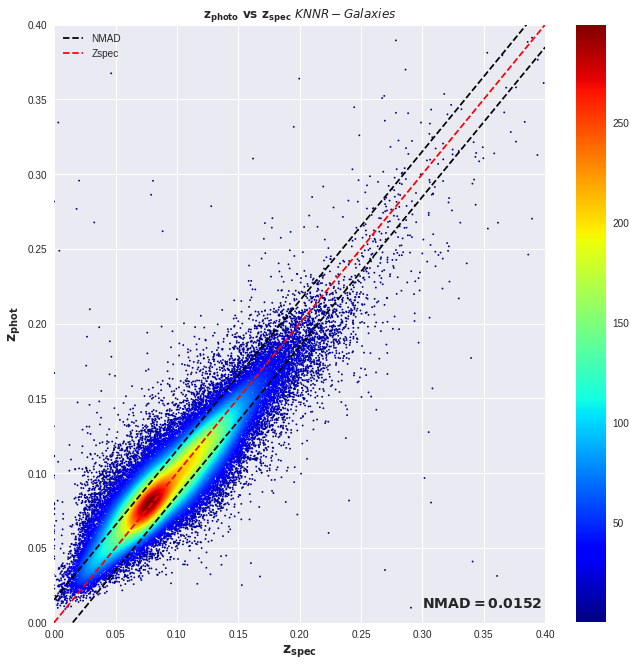

In [87]:
denplot(ztest_knng , zpred_knng, r'$\mathbf{z_{photo}\ vs\ z_{spec}}\ KNNR-Galaxies$', typ = 'GALAXY') 

# QSO

delta(z)_mean = 0.008176207542419434; delta(z)_median = 0.000726262223906815; sigma(delta(z)) = 0.10626594722270966; nmad(delta(z)) = 0.03842299378886819
sigma1 = 7.779292645761489; sigma2 = 3.3202341807683053; sigma3 = 2.1373005052530276; sigma0.15 = 5.000400994466276


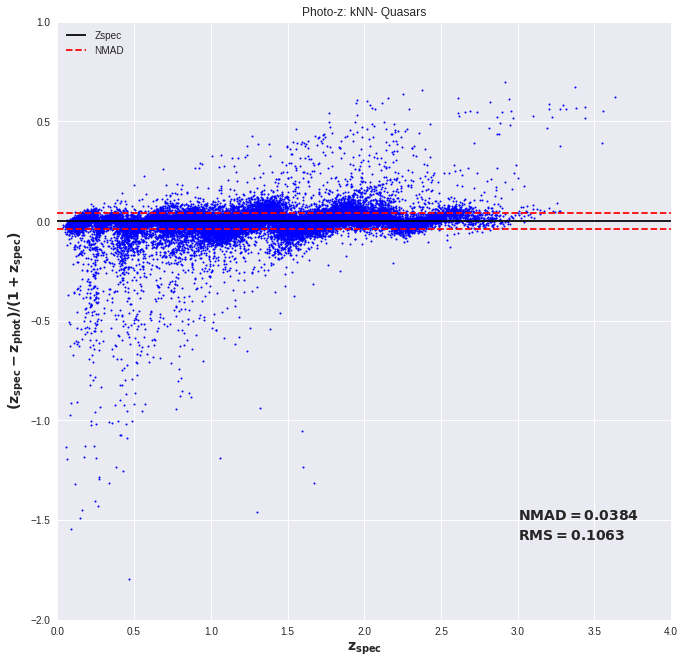

In [88]:
# kNearestRegressor for QSO
# using 10 nearest neighbors 
kg = KNeighborsRegressor(n_neighbors=10, leaf_size = 4, p = 1, weights='uniform')
ztest_knnq , zpred_knnq = regressor(kg,x_data,y_data, i_gal, i_qso, 'kNN', '', [[0.0,4.0],[-2.0,1.0]])

delta(z)_mean = 0.002729829866439104; delta(z)_median = -0.0007257350953295827; sigma(delta(z)) = 0.1393490731716156; nmad(delta(z)) = 0.03830862111523747
sigma1 = 5.120699334349186; sigma2 = 2.233539177159355; sigma3 = 1.0626353356323681; sigma0.15 = 4.691635255433475


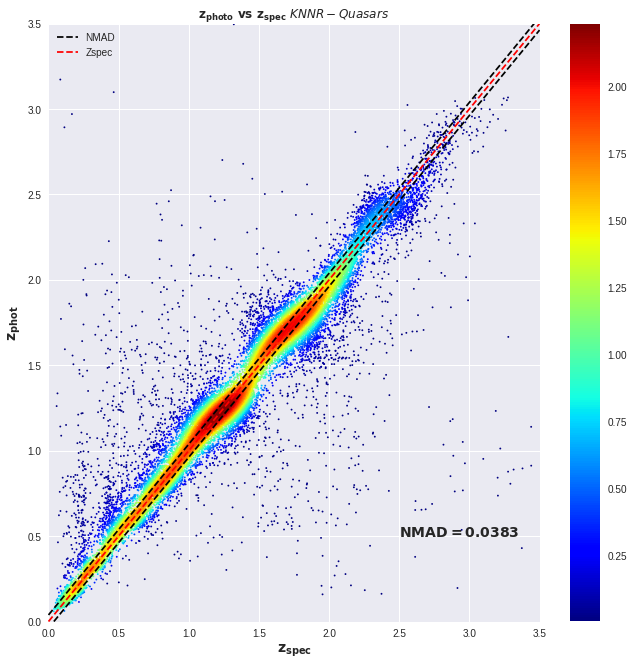

In [89]:
denplot(ztest_knnq , zpred_knnq, r'$\mathbf{z_{photo}\ vs\ z_{spec}}\ KNNR-Quasars$', 'QSO') 

In [90]:
# Calculating the score of the model

from sklearn.metrics import r2_score

print('r2 score for galaxies using random forest:', r2_score(ztest_rfg, zpred_rfg))
print('r2 score for QSO using random forest:', r2_score(ztest_rfq, zpred_rfq))
print('r2 score for galaxies using KNNR:', r2_score(ztest_knng, zpred_knng))
print('r2 score for QSO using KNNR:', r2_score(ztest_knnq, zpred_knnq))

r2 score for galaxies using random forest: 0.7657154984495782
r2 score for QSO using random forest: 0.8793976722470369
r2 score for galaxies using KNNR: 0.7275447789549638
r2 score for QSO using KNNR: 0.8430782859136202


Random forest basics
https://levelup.gitconnected.com/random-forest-regression-209c0f354c84
    
Random forest hyperparameter tuning
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    
Guide to linear regression
https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f
    
    
    
KNN regression

Hyperparameters tuning
https://medium.com/datadriveninvestor/k-nearest-neighbors-in-python-hyperparameters-tuning-716734bc557f

Intro to KNNR
https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/